In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import binarize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
import json

fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--3.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--6.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--7.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--8.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--1.data.json'
with open(fn) as f:
    data = json.load(f)
    d = data["data"]
    spec = data["spec"]

print(spec)
print(d[0])

n_obs = len(d)
print('nb_records:', n_obs)

{'version': 1, 'min_number_of_gems': 12, 'min_months': 10, 'min_nloc': 2000, 'min_months_good': 20, 'history_months': 20, 'stopped_time_point': '2015-01-01 00:00:00 UTC', 'min_months_bad': 10, 'ignored_months_for_good': 10}
{'name': 'actionwebservice', 'version': '1.2.6', 'stat': {'nloc': 5601, 'avg_ccn': 1.7, 'avg_nloc': 6.9, 'avg_token': 37.2, 'fun_count': 625, 'warning_count': 6.248884127834315, 'fun_rate': 0.06, 'nloc_rate': 0.24, 'style_': 62.13176218532405, 'lint_': 11.247991430101768, 'lint_duplicate': 0.17853954650955187, 'metrics_abcsize': 1.6068559185859668, 'metrics_blocklength': 0.5356186395286556, 'metrics_blocknesting': 0.0, 'metrics_classlength': 0.8926977325477593, 'metrics_cyclomaticcomplexity': 0.5356186395286556, 'metrics_linelength': 1.428316372076415, 'metrics_methodlength': 0.8926977325477593, 'metrics_modulelength': 1.0712372790573113, 'metrics_parameterlists': 0.7141581860382075, 'metrics_perceivedcomplexity': 1.249776825566863, 'total': 0.7141581860382075, 'Dup

In [4]:
df = pd.io.json.json_normalize(d)

old_new_cols = {}
for name in df.columns:
    if name.startswith('stat'):
        old_new_cols[name] = name.split('.')[1]

df.rename(columns=old_new_cols, inplace=True)
df.head()

,label,name,Attribute,BooleanParameter,ClassVariable,ControlParameter,DataClump,DuplicateMethodCall,FeatureEnvy,InstanceVariableAssumption,...,metrics_methodlength,metrics_modulelength,metrics_parameterlists,metrics_perceivedcomplexity,nloc,nloc_rate,style_,total,warning_count,version
0,good,actionwebservice,4.284949,0.357079,0.000000,1.785395,1.249777,36.779147,7.498661,7.855740,...,0.892698,1.071237,0.714158,1.249777,5601,0.24,62.131762,0.714158,6.248884,1.2.6
1,good,active_metadata,3.319109,1.422475,0.474158,0.948317,0.000000,23.233760,2.844950,6.638217,...,4.267425,0.000000,0.948317,0.948317,2109,0.03,84.400190,3.319109,1.422475,0.8.9
2,good,acts_as_ferret,2.336449,1.298027,1.817238,1.038422,0.778816,100.467290,7.268951,6.230530,...,0.778816,0.778816,0.000000,1.557632,3852,0.12,84.112150,0.000000,4.932503,0.5.4
3,good,adapi,4.763099,1.504136,0.501379,1.504136,0.000000,21.308599,1.754826,4.011030,...,1.253447,0.000000,0.000000,2.256205,3989,0.47,61.920281,1.504136,5.264477,0.2.0
4,good,adaptation,2.103492,0.000000,0.841397,2.103492,1.262095,38.283551,9.255364,4.206984,...,2.524190,0.420698,0.841397,3.786285,2377,0.28,121.161127,3.365587,8.834666,1.0.1


In [5]:
rows_with_NaNs = pd.isnull(df).any(1).nonzero()[0]
print(df.ix[rows_with_NaNs][['name', 'version']])

Empty DataFrame
Columns: [name, version]
Index: []


In [6]:
print(df.shape)
if len(rows_with_NaNs) > 0:
    df.dropna(inplace=True)
    print(df.shape)

(1014, 53)


In [7]:
exclude = ['avg_nloc',]
features = [k for k, v in d[0]['stat'].items() if k not in exclude]

X = df[features]
y = (df.label == 'good').values.astype(int)

In [8]:
def label_counts_summary(data, label='unknow'):
    N = len(data)
    N_ones = data.sum()
    print('''
label: {}
nb. of observations: {}
nb. of ones (good gems): {}
frequency: {:.3f}
    '''.format(label, N, N_ones, 1.0 * N_ones / N))

In [9]:
label_counts_summary(y, label='Full set')

# split full dataset into 70% training and 30% test data
# test data is used only to evalute the model's prediction performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

label_counts_summary(y_train, label='Training set')
label_counts_summary(y_test, label='Test set')


label: Full set
nb. of observations: 1014
nb. of ones (good gems): 389
frequency: 0.384
    

label: Training set
nb. of observations: 709
nb. of ones (good gems): 277
frequency: 0.391
    

label: Test set
nb. of observations: 305
nb. of ones (good gems): 112
frequency: 0.367
    


# Classify using LogisticRegression

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))  # % of correct predictions

             precision    recall  f1-score   support

          0       0.66      0.88      0.75       193
          1       0.51      0.22      0.31       112

avg / total       0.61      0.64      0.59       305

0.63606557377


In [11]:
# generate predictions based on classification probability
y_pred_proba = model.predict_proba(X_test)

print(y_pred_proba[:3])

thresh = 0.6
y_pred_good = binarize([y_pred_proba[:,1]], thresh)[0]

print(metrics.accuracy_score(y_test, y_pred_good))

[[ 0.64193512  0.35806488]
 [ 0.59555506  0.40444494]
 [ 0.74005331  0.25994669]]
0.64262295082


## k-fold cross-validation

Split data into 10 blocks and use 1 as testing and 9 others as training. Repeat 10 times with different block as testing block. Good for verifying dependency on outliers.

In [12]:
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean(), scores.std())

[ 0.6372549   0.68627451  0.60784314  0.62745098  0.56862745  0.66336634
  0.58415842  0.58415842  0.61386139  0.58      ]
0.615299553485 0.0366047887216


# Classify using kNN

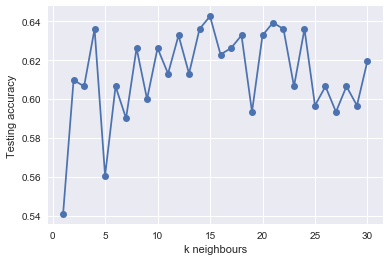

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

nb_range = np.arange(1, 31)
a_scores = []

for nb in nb_range:
    model = KNeighborsClassifier(n_neighbors=nb)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    a_scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(nb_range, a_scores, 'o-')
plt.ylabel('Testing accuracy')
plt.xlabel('k neighbours')

In [14]:
from sklearn.grid_search import GridSearchCV

/Users/terry/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [15]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)


# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.6035502958579881
{'n_neighbors': 6, 'weights': 'uniform'}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')
